# iLykei Lecture Series   
# University of Chicago   
# Financial Analytics (MScA 32001)


# A Stop-Loss Algorithm Based on Limit Order Book, Part 1

### Y.Balasanov, M.Tselishchev, © iLykei 2015-2022

* [Introduction](#Introduction)
* [Technical Description](#TechnicalDescription)
* [Penalty Function](#PenaltyFunction)


***Team iLykei: A. Petukhov, M. Tselishchev***

## 1. Introduction <a name="Introduction"></a>

When you trade on exchange you can place a special type order to your brokerage called **stop-loss order**.     

For example, you buy $N$ shares of SPDR S&P 500 ETF SPY at 200.00. The market moved up to 201.50. You would like to continue holding on to the position, but don't want to lose all your gains.      
You can send a stop-loss order to your brokerage and ask to sell $N$ shares of SPY if the price goes down from 201.50 to 201.     
Upon receiving your order the brokerage enters your order into their monitoring system which automatically executes the sell order for $N$ shares of SPY as soon as the price touches the level of 201.00.     

How does the algorithm of the brokerage decide when to trigger the execution?      

The algorithm monitors the best (highest) bid price. As soon as the top of the book bid price drops to 201.00 the algorithm sends a limit order or market order to sell at the price of the best bid at 201.00.     

**Why brokerage does not send limit order to sell at 201 ahead of time, but only at the time of first touch of 201 by best bid price?**     

**Does this algorithm guarantee that the order gets executed exactly at 201.00?**

Look at the 
<a href="https://ilykei.com/api/fileProxy/documents%2FMSFM%20Mathematical%20Market%20Microstructure%2FLecture%201%2036702%2FSeptember172015SPY.png" target="_blank">price chart</a>
for September 17, 2015.      
Stop-loss order at 199 would have not been executed.     

There are other situations when stop-loss order may not be executed, for example the price moved through the level faster than our ability to execute orders.     

Stop-loss orders may become visible once they are entered.      
If some party has access to information on where stop-loss levels are concentrated that information can be used to manipulate the market by temporarily pressing the price to a level where large number of stop-loss orders are triggered. After stop-loss orders are triggered and executed the price usually goes back making gains for stop-loss predator.      

There are also some known patterns in setting stop-loss levels. People often set them at round numbers or at levels known to be support levels.

For these reasons it might be better to develop a proprietary algorithm that monitors the market and sends market or limit order when necessary without showing your intentions anywhere outside your server.

There is a subtle difference between stop-loss order and limit-stop order.      
The former results in a market order once it is triggered. The latter results in a limit order.     

Once the price has moved through the stop-loss level the algorithm should sell $N$ shares of SPY immediately at best available price, even if this price is lower than the desired level.     

Stop-loss order to buy would make the brokerage algorithm monitor the best ask price to decide when to trigger the trade.     

The goal of this project is to create a stop-loss algorithm using dynamic best bid and best ask price levels as well as best bid and best ask book sizes.

Watch dynamic changes of the limit order book in this 
<a href="https://ilykei-public.s3-us-west-2.amazonaws.com/LimitOrderBookAnimation/orderbook_animation.html" target="_blank">animation</a>.      
Observe how limit order book sizes are related to change in price level.      

The asset traded in this example is S&P e-mini futures contract ESU5 with expiration in September of 2015.     
The trade day is August $28^{th}$, 2015.      
See [specifications](https://www.cmegroup.com/trading/equity-index/us-index/sandp-500_contract_specifications.html) of the contract on CME web site.      

The definition of stop-loss algorithm in this project is a little more general:      
The price may pass through the predetermined level multiple times.      
The algorithm protects short position in one futures contract.       
The stop-loss level is usually called 'barrier' and is equal $1984.00$ in the workshop mode and $1981.00$ in the test mode (note that all prices in the following code are multiplied by `100`, so barriers should be `198400` and `198100` accordingly).     
Every time the price passes up through the given barrier the algorithm must buy one contract to liquidate the position.      
Every time the price goes down through the same level the algorithm must put the position back again by selling 1 contract.      
Initially the price is below the barrier.      
The base position of one short futures contract is not reflected in the position of the algoritm, i.e. after passing the barrier up from below the position of the algoritm becomes +1; if price moves below the the barrier the position of the algorithm is 0.     
If the algorithm misses the level it is forced to execute the trade at the best available price by a market order. This trade is initiated by the risk system and will be called "forced".    


## Technical Description <a name="TechnicalDescription"></a>


Connect to data-streaming server using your credentials, listen to top-of-the-book stream flow and send orders in real time. 

Download the archive `HFT1ProjectMaterials_py_MSFM37602.zip` containing the following files:

 * ***hft1_train.csv*** - csv-file with top-of-the-book statistics for one day, which is used for training; it contains timestamp (microseconds since start of the session), best bid price (multiplied by `100`), bid size, best ask price (multiplied by `100`) and ask size;
 * ***hft1_connection.py*** - python source file which contains methods providing connection and authentication to the data-streaming server;
 * ***hft1.proto*** & ***Authentication.proto*** - proto-files, describing internal messages structure;
 * ***hft1_client.ipynb*** - this file contains an example of event handlers and `connect()`-call.

In [1]:
## install necessary libs & compile proto-files

# !pip install matplotlib tk pandas protobuf
# !protoc --python_out=./ *.proto

In [2]:
# select appropriate matplotlib backend

# %matplotlib notebook
#%matplotlib qt
# %matplotlib tk

In [3]:
from datetime import datetime
import pandas as pd
import pickle
import matplotlib.pyplot as plt

Create global variables to store marketdata.

In [4]:
# global vars
# !!! barrier should be changed to 198100 for test assignment !!!
barrier = 198100  # multiplied by 100 since prices are also multiplied by 100
tick = 25  # S&P500 futures tick, also multiplied by 100
position = 0  # current position

bidask_event_counter = 0  # bid-ask change event counter
orderexec_counter = 0  # order execution event counter
BUF_SIZE = 10000  # we create buffers in advance:
bidask_df = pd.DataFrame(index=range(0, BUF_SIZE),
                         columns=['time', 'bid_price', 'bid_size', 'ask_price', 'ask_size'])
executed_orders = pd.DataFrame(index=range(0, BUF_SIZE), # dataframe for executed orders
                               columns=['time', 'side', 'quantity', 'price', 'forced'])
start_time = datetime.now()

Write your own handlers to process incoming messages.

These handlers are just functions that automatically called every time a message arrives.      

When the message contains a change in the orderbook, there is a call of `bidask_handler`.      
It takes 4 arguments received in the message — `bid_price`, `bid_volume`, `ask_price` and `ask_volume` (all of them are integers).
Note that all prices are multiplied by `100`, to turn them into integers.
This handler must return `1` to buy at the best ask price, `-1` to sell at the best bid price, or `0` to do nothing.

In the example below we buy one contract when bid price is equal or greater than the barrier and sell when ask price is equal or less than the barrier.

In [5]:
# bidask_handler is expected to have 4 arguments
# 1) bid_price (multiplied by 100),
# 2) bid_size (int),
# 3) ask_price (multiplied by 100),
# 4) ask_size (int),
# and to return 1 to buy@ask, -1 to sell@bid and 0 to do nothing
def bidask_handler(bid_price, bid_size, ask_price, ask_size):
    global bidask_event_counter, bidask_df
    now = datetime.now()
    # update bidask_df dataframe
    bidask_df.loc[bidask_event_counter] = [now, bid_price, bid_size, ask_price, ask_size]
    bidask_event_counter += 1
    draw()  # plot once in a second
    
    ### REPLACE THE CODE BELOW WITH YOUR LOGIC
    # calc signal
    signal = 0
    if bid_price >= 1.10 * barrier and position <= 0:
        signal = +1
    elif ask_price <= 1.0 * barrier and position > 1:
        signal = -1

    if signal != 0:
        print('Sending signal: ', signal)
    return signal

When your order is matched by the matching engine and we receive a message with the executed trade. Upon arival of this message the second event handler - `orderexec_handler` - is automatically called.      
It has 4 arguments contained in the message:    
- `side` (`'BOUGHT'` or `'SOLD'`),    
- `quantity` (int),  
- `price` (int) and    
- `forced` (boolean), value of which is `True` when the order is initiated by the system.
Note that trade price is also multiplied by `100`.

In [6]:
# orderexec_handler has 4 arguments:
# 1) side ('BOUGHT' or 'SOLD')
# 2) quantity (int), always positive
# 3) price (int) - also multiplied by 100
# 4) forced (logical) - TRUE when the order is initiated by the system
# and to return nothing
def orderexec_handler(side, quantity, price, forced):
    global orderexec_counter, executed_orders, position
    now = datetime.now()
    print(f'{now} : {side} @ {price} (forced={forced})')
    # update executed_orders dataframe
    executed_orders.loc[orderexec_counter] = [now, side, quantity, price, forced]
    orderexec_counter += 1
    # update current position
    if side == 'BOUGHT':
        position += quantity
    elif side == 'SOLD':
        position -= quantity
    draw()  # plot once in a second
    return

You can modify the logic of the handlers with any other appropriate logic. Do not forget to use **global**-statement if the change of global variable is required inside of the handler.


You can also use the following function `draw()` which re-plots the graph of the stream and communication every second.

C:\Users\jasme\AppData\Local\Temp\ipykernel_29468\2984966741.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


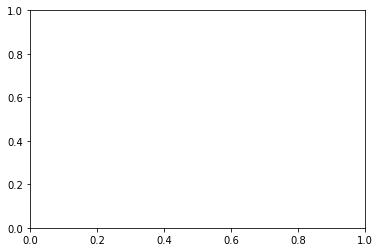

In [7]:
import numpy as np
plot_timestamp = datetime.now()  # last plotting time, we use it to plot once a second
plt.ion()  # matplotlib interactive mode ON
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

In [8]:
[datetime.now() for i in range(len(bidask_df.time[:bidask_event_counter]))]

[]

In [9]:
bidask_df.time[:bidask_event_counter] - [datetime.now() for i in range(len(bidask_df.time[:bidask_event_counter]))]

Series([], Name: time, dtype: object)

In [10]:
def draw():
    global plot_timestamp, fig, ax
    now = datetime.now()
    if (now - plot_timestamp).total_seconds() >= 1:
        plot_timestamp = now
        if bidask_event_counter > 0:
            ax.clear()
            ax.axhline(y=barrier, c='k')  # barrier line
            ba_time_values = (bidask_df.time[:bidask_event_counter] - [start_time for i in range(len(bidask_df.time[:bidask_event_counter]))]).dt.total_seconds()
            ax.plot(ba_time_values, bidask_df.bid_price[:bidask_event_counter], ds='steps-pre', alpha=0.5, c='b')
            ax.plot(ba_time_values, bidask_df.ask_price[:bidask_event_counter], ds='steps-pre', alpha=0.5, c='purple')
            if orderexec_counter > 0:
                exord_good_df = executed_orders.head(orderexec_counter)
                tr_time_values = (exord_good_df.time - [start_time for i in range(len(exord_good_df.time))]).dt.total_seconds()
                client_buy_idx = (exord_good_df.side == 'BOUGHT') & (~exord_good_df.forced)
                client_sell_idx = (exord_good_df.side == 'SOLD') & (~exord_good_df.forced)
                forced_buy_idx = (exord_good_df.side == 'BOUGHT') & exord_good_df.forced
                forced_sell_idx = (exord_good_df.side == 'SOLD') & exord_good_df.forced
                ax.plot(tr_time_values[client_buy_idx], exord_good_df.price[client_buy_idx], 
                         'og', ms=7, label='client buy')  # green circles
                ax.plot(tr_time_values[client_sell_idx], exord_good_df.price[client_sell_idx], 
                         'or', ms=7, label='client sell')  # red circles
                ax.plot(tr_time_values[forced_buy_idx], exord_good_df.price[forced_buy_idx], 
                         'sg', ms=7, label='forced buy')  # green squares
                ax.plot(tr_time_values[forced_sell_idx], exord_good_df.price[forced_sell_idx], 
                         'sr', ms=7, label='forced sell')  # red squares
                ax.legend(loc='best')
            plt.xlabel('time (seconds)')
            plt.ylabel('price')
            fig.canvas.draw()

When the handlers are ready, connect to the live stream.     
The following function connects to the data-streaming server, makes authentication, listens to server data stream, uses the handlers to process new events and sends replies back to server.    

Create a file, for example, `my_credentials.txt` with 2 lines: first line contains the email address, second line contains the streaming password.   
Read this file to prepare variables for authentication.

In [11]:
import sys
sys.path.append('.')

In [14]:
%%time
from hft1_connection import connect

# server options
host = 'datastream.ilykei.com'
port = 30401 # DO NOT CHANGE
login = 'jasmeetsingh@uchicago.edu'          # your email
password = 'X7TeapXp'    # your streaming password
stream_name = 'hft1'
catch_handler_errors = True  # we recommend using TRUE during the test and FALSE during the workshop mode

# make connection with your event handlers
result = connect(host, port, login, password, stream_name,
                 bidask_handler, orderexec_handler, catch_handler_errors)

Connecting to datastream.ilykei.com:30401
Sending login message
Logged in successfully as  jasmeetsingh@uchicago.edu
!!!***   WARNING   ***!!!
 Error inside bidask_handler: unsupported operand type(s) for -: 'DatetimeArray' and 'list'. Forcing signal to 0 
!!!*******************!!!
!!!***   WARNING   ***!!!
 Error inside bidask_handler: unsupported operand type(s) for -: 'DatetimeArray' and 'list'. Forcing signal to 0 
!!!*******************!!!
!!!***   WARNING   ***!!!
 Error inside bidask_handler: unsupported operand type(s) for -: 'DatetimeArray' and 'list'. Forcing signal to 0 
!!!*******************!!!
!!!***   WARNING   ***!!!
 Error inside bidask_handler: unsupported operand type(s) for -: 'DatetimeArray' and 'list'. Forcing signal to 0 
!!!*******************!!!
!!!***   WARNING   ***!!!
 Error inside bidask_handler: unsupported operand type(s) for -: 'DatetimeArray' and 'list'. Forcing signal to 0 
!!!*******************!!!
!!!***   WARNING   ***!!!
 Error inside bidask_handle

The last argument is logical `catch_handler_errors`.     
When its value is `True`, an event loop inside `connect()` will catch every error inside student's handlers, so the program won't crash.     
However, it might be useful to switch that option off during preparation at home in order to detect problems inside the handler.

If everything was fine, the function continues working until the server stops its stream.   

In the final message server sends the penalty value, which is printed to the console.      
It also returns the list containing the results of the session, including some statistics and observed problems.

Finally, it is highly recommended to dump these results and, possibly, some other data that you may find useful to local file:

In [15]:
# remove empty values from buffers
bidask_df = bidask_df.head(bidask_event_counter)
executed_orders = executed_orders.head(orderexec_counter)

# after all you can dump your data/results and analyze it later
with open('results.pkl', 'wb') as output_f:
    pickle.dump([bidask_df, executed_orders, result], output_f)

## Penalty Function <a name="PenaltyFunction"></a>

Profit and loss value (P&L) of trading around the barrier (multiplied by 100) serves as penalty function.    
It is defined as
$$ \sum_{\mathrm{buys}} (barrier-buy\_price) + \sum_{\mathrm{sells}} (sell\_price-barrier).$$
Larger P&L means better results.

Note that the algorithm can trade only one contract (i.e. position is either 0 or 1).
Also note that the server will *force* buying order when the price gets above the barrier and will *force* selling order when the price gets below the barrier.

**Target for the project test**: loss less than 350 (greater than -350).